In [1]:
import collections
import re
from d2l import torch as d2l

# d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt','090b5e7e70c295757f55df93cb0a180b9691891a')


In [ ]:
def read_time_machine(): #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open('mypaper.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
lines = read_time_machine()

# 文本总行数: 322
does strengthened environmental law
junhao kong


In [3]:
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
    
tokens = tokenize(lines)
for i in range(5):
    print(tokens[i])

['does', 'strengthened', 'environmental', 'law']
['enforcement', 'improve', 'regulatory', 'efficiency']
['causal', 'evidence', 'from', 'china']
[]
['junhao', 'kong']


In [4]:
class Vocab: #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self): # 未知词元的索引为0
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
        
def count_corpus(tokens): #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
    # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('environmental', 2), ('and', 3), ('of', 4), ('in', 5), ('to', 6), ('efficiency', 7), ('courts', 8), ('a', 9)]


In [6]:
for i in [0, 3]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['does', 'strengthened', 'environmental', 'law']
索引: [204, 59, 2, 27]
文本: []
索引: []


In [24]:
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(45928, 28)

In [ ]:
import random
import torch
from d2l import torch as d2l

tokens = tokenize(read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 302),
 ('environmental', 262),
 ('and', 214),
 ('of', 183),
 ('in', 129),
 ('to', 97),
 ('efficiency', 91),
 ('courts', 69),
 ('a', 56),
 ('s', 54)]

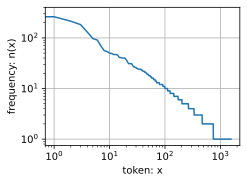

In [10]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
xscale='log', yscale='log')

In [11]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('environmental', 'courts'), 63),
 (('of', 'environmental'), 47),
 (('regulatory', 'efficiency'), 46),
 (('environmental', 'regulatory'), 36),
 (('environmental', 'governance'), 25),
 (('establishment', 'of'), 24),
 (('law', 'enforcement'), 23),
 (('the', 'establishment'), 22),
 (('public', 'participation'), 22),
 (('in', 'the'), 22)]

In [12]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('environmental', 'regulatory', 'efficiency'), 35),
 (('of', 'environmental', 'courts'), 24),
 (('the', 'establishment', 'of'), 22),
 (('establishment', 'of', 'environmental'), 21),
 (('environmental', 'law', 'enforcement'), 19),
 (('strengthened', 'environmental', 'law'), 15),
 (('significant', 'at', 'significant'), 12),
 (('at', 'significant', 'at'), 12),
 (('that', 'environmental', 'courts'), 10),
 (('that', 'strengthened', 'environmental'), 9)]

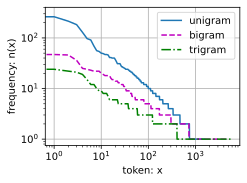

In [13]:
bigram_freqs = [freq for _, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for _, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
ylabel='frequency: n(x)', xscale='log', yscale='log',
legend=['unigram', 'bigram', 'trigram'])

In [14]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [15]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[11, 12, 13, 14, 15],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[16, 17, 18, 19, 20],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [ 7,  8,  9, 10, 11]])
X:  tensor([[26, 27, 28, 29, 30],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]])


In [16]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [17]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [25]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [26]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
    batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

perplexity 1.0, 254674.0 tokens/sec on cuda:0
environment regulation first we employ a non desirable output slacks base
difference in regulatory efficiency robustness checks confirm


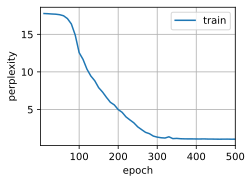

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import math


def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            d2l.grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            d2l.grad_clipping(net, 1)
            # 因为已经调用了`backward`函数，所以`updater`函数需要执行`step`函数来更新参数
            updater(batch_size=1)
        
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(net, nn.Module):
        updator = torch.optim.SGD(net.parameters(), lr)
    else:
        updator = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            net, train_iter, loss, updator, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('environment regulation '))
            animator.add(epoch + 1, [ppl])
    
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('environment regulation '))
    print(predict('difference '))
    

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
vocab_size, num_hiddens, num_layer = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layer)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)


In [31]:
predict = lambda prefix: d2l.predict_ch8(prefix, 50, model, vocab, device)

predict('envi')

'environmental lawenforcement improve regulatory effici'